# Example Notebook 3: Generating Equilibrium Configurations
Here we provie a minimal working example of generating ion equilibrium configurations.

In order to run simulations with this code, the system must start in a pre-provided state. Usually this state is a position of stable equilibrium of the system. These positions of stable equilibrium depend on N and gamma and nothing else. A handful of pre-generated positions are already included with the code in the "input" folder, but this document explains how you can generate these yourself for arbitrary N and gamma.

In [1]:
import os
import numpy as np
from simulation_module import SimulationConfig, SimulationState, SimulationRunner, SimulationIO, SimulationVisualizer, AnimationMaker
from time import time
import utility_functions as utility

input_path = "input"
output_path = "output"

# Configure our simulation object with 8 ions, and gamma = 1. NOTE THAT MOST PARAMETERS IN THE CONFIG ARE NOT IMPORTANT HERE
config = SimulationConfig(
    N = 8,                        # number of ions
    w = 1.0,                      # frequency in the trap harmonic potential
    g = 1,                        # isotropy factor
    m = 137.327,                  # mass in atomic units
    T_mK = 0,                     # temperature in mK
    dt = 10**-3,                  # timestep
    num_steps = int(5*10**4),     # number of simulation steps
    damping = False,              # damping is turned off for now
    damping_parameter = 1.0,      # since damping is turned off, the strength of the damping parameter is not relevant
    langevin_temperature = False, # langevin_temperature is turned off for now (no random motion)
    lasers=[],                    # we have no lasers
    input_path = input_path,      # this is the input file we won't use
    output_path = output_path     # this is where we will put all outputs
)

state = SimulationState(config)

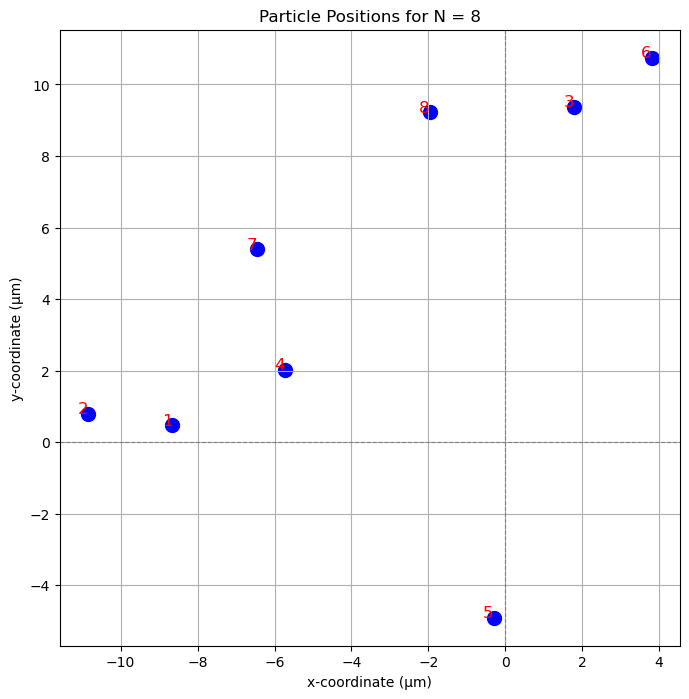

In [2]:
# Let's start by initializing the ions at random positions within a circle of predetermined radius given by utility.base_radius
state.initialize_positions(method = "random")
SimulationVisualizer().plot_positions(state, square = False)

🔍 Minimizing potential energy for N = 8 ions...
✅ Minimization complete. Final energy: 322411.5804 κ 
🔍 Solving for force balance (∑F = 0) for N = 8 ions...
✅ Force minimization complete. RMS force: 2.5890819063277678e-08 amu·μm·μs⁻²


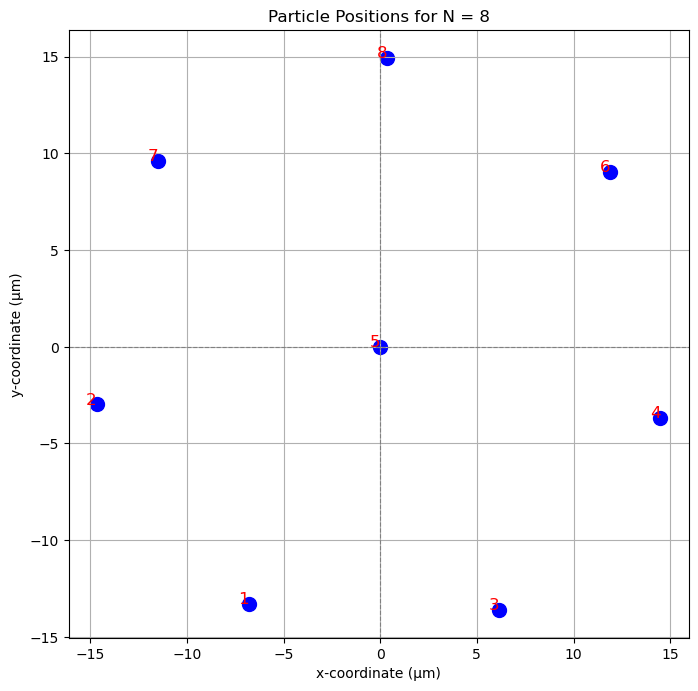

In [3]:
# Now we can use a little bit of trial and error to find stable configurations

# This tries to minimize the energy of the system, but it often struggles to find the best solution
state.minimize_energy()

# This tries to minimize the forces of the system, but it often finds positions of UNSTABLE equilibrium
state.minimize_forces()

# Visualize positions
SimulationVisualizer().plot_positions(state)

Try running the above two cells a few times and notice that sometimes you get different results. For 8 ions, there are two configurations that the system likes to spit out. The first (configuration A) has a ring of 6 ions encompassing two central ions and has an energy of roughly 324034.5071 κ and the second one (configuration B) has a ring of 7 ions encompassing a single central ion with an energy of roughly 322411.2742 κ. Directly comparing the energy shows that the configuration with a single ion in the centre is of a lower energy. It is however still possible that configuration A is stable, just a local minima of the energy as opposed to a global minimum. 

To check if we indeed have a position of *stable* equilibrium, it can be helpful to run the simulation for a little while and see how much the positions drift

In [4]:
# Initialize the runner
runner = SimulationRunner(config, state)

In [5]:
# Test for stability by running the simulation for 1000 timesteps
stability_steps = 1000
runner.display_stability(stability_steps = stability_steps)

Running with isotropy (γ) = 1.0000 for 1.0 μs
After running the simulation for 1000 steps (1.0 μs of simulation time), the RMS positional deviation is about 2.7872910962230995e-08 μm. For 1000 steps and 1 μs, any RMS deviation above about 10^-5 μm indicates instability.


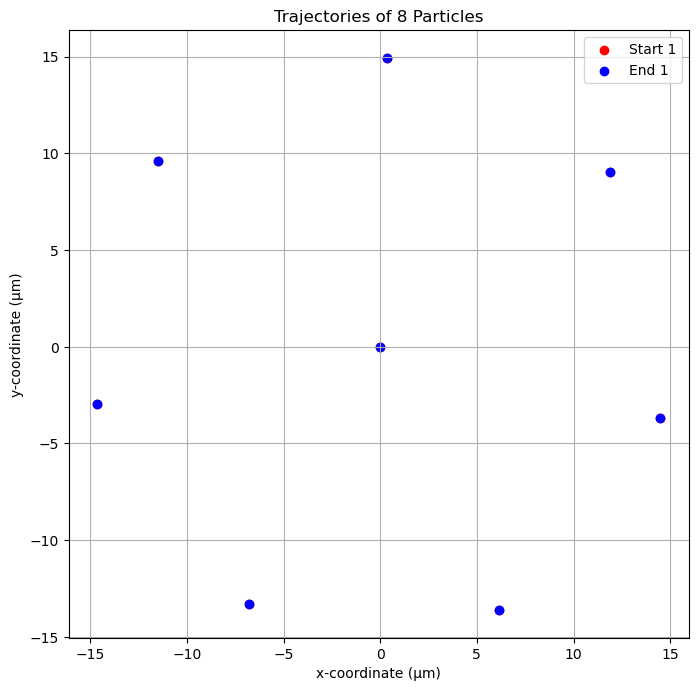

In [6]:
# We can visualize the trajectory over those 1000 timesteps and notice that nothing has changed:
SimulationVisualizer().plot_trajectory(state, max_index = stability_steps) 

# Note the importance of max_index = stability_steps. See what happens when you remove this.
# Since our stability test only ran the simulation for 1000 timesteps, but the config provides many more timesteps,
# if you run without max_index = stability_steps, the trajectory is plotted inclusive of all of the initialization
# zeros present initially in state.trajectory.

## Saving a configuration to file

Once you have found a configuration that you wish to save, it is easy to do so

In [7]:
# The below will save the .json file to the folder output_path. Note that when you load positions, the positions
# will be loaded from input_path. If neither input_path, nor output_path are arguments provided to SimulationIO
# then the files are simply opened from and saved to the main directory.
IO = SimulationIO(input_path = input_path, output_path = output_path)
IO.save_positions(positions = state.positions, filename = f"{config.N}_{config.g}_positions_1.json")

## Extreme values of gamma
Sometimes we wish to generate stable configurations of ions in highly asymmetric potentials (i.e. with a very small value of gamma). In this case the resulting configuration is linear, but the minimization functions sometimes have a hard time finding them. Let's see the problem.

🔍 Minimizing potential energy for N = 8 ions...
✅ Minimization complete. Final energy: 88810.8272 κ 
🔍 Solving for force balance (∑F = 0) for N = 8 ions...
✅ Force minimization complete. RMS force: 5.260479735735367e-08 amu·μm·μs⁻²


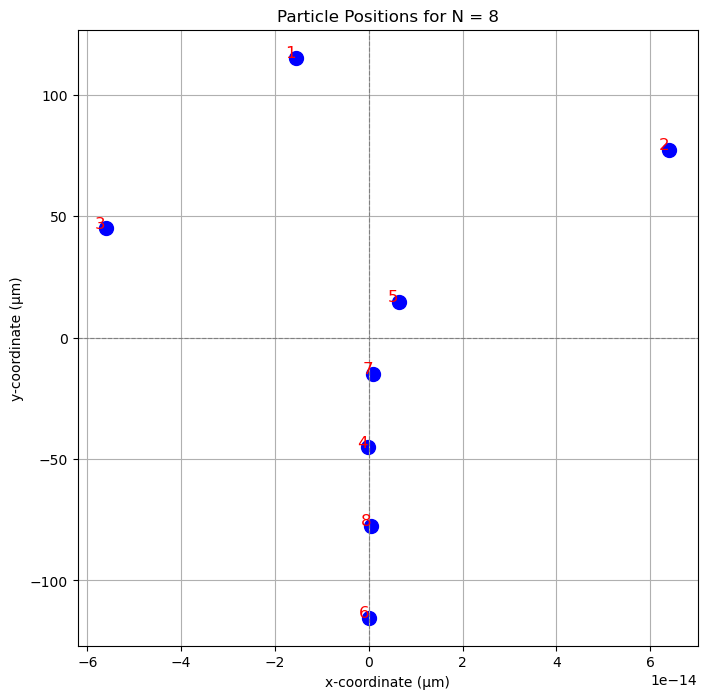

In [8]:
# Set the gamma to be very small and minimize energy/forces
config.g = 0.1
state = SimulationState(config)
state.initialize_positions(method = "random")
state.minimize_energy()
state.minimize_forces()
SimulationVisualizer().plot_positions(state, square = False)

Making note of the x-axis scale on the above plot, we see that the resultant configuration is linear (to within tiny numerical errors). These errors may bug you a little, which can simply be resolved by hard-coding the x-positions to zero via:

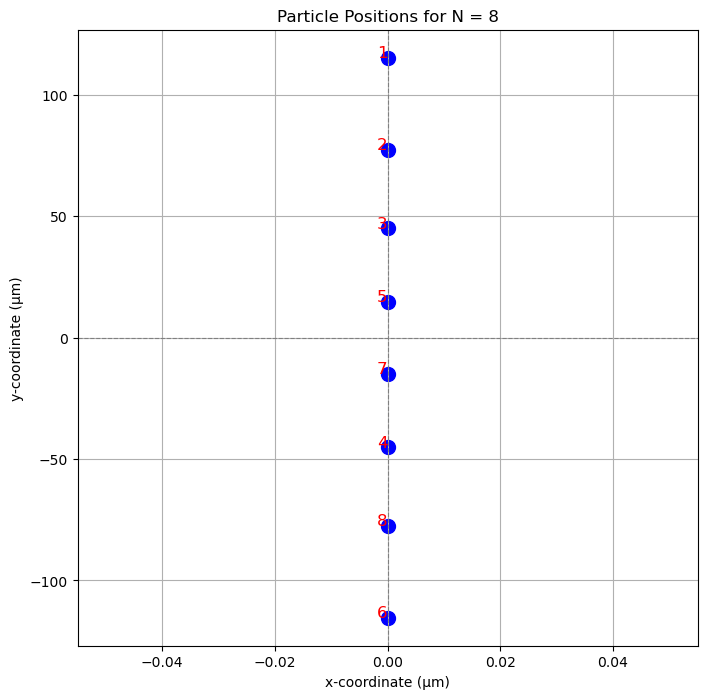

In [9]:
state.positions = np.array([[0,x[1]] for x in state.positions])
SimulationVisualizer().plot_positions(state, square = False)

Note however that if the x-axis positions of the ions are all zero, then when a quench to larger gamma is performed, since this is indeed a position of (albeit unstable) equilibrium, the forces on the ions are indeed all zero, and so the ions may not move from their positions. To counter this, it is useful to have tiny deviations in the x-coordinate of the ions. We can add this in manually, to be able to control it via the below code: 

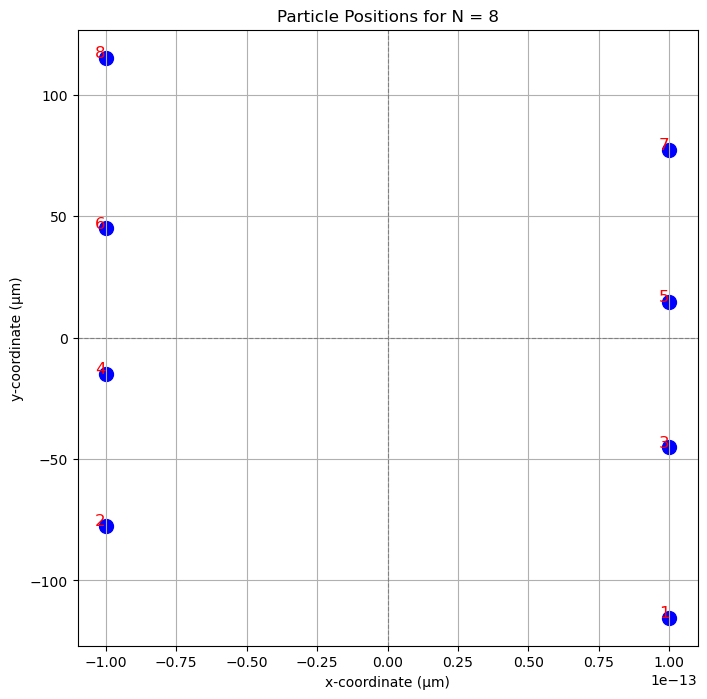

In [13]:
# Build the oscillation pattern:
deviation_magnitude = 1e-13

# Produce zigzag pattern:
pattern = deviation_magnitude * utility.zigzag(config.N)

# We can also produce a zigzag DEFECT pattern with a defect at position 3 by uncommenting the line below:
# pattern = deviation_magnitude * utility.zigzagdefect(config.N, 3)
    
# Sort state.positions on the y-axis value so that it lines up
state.sort_positions(axis = 1)
    
# Display the positions
state.positions = np.array([[pattern[i],state.positions[i,1]] for i in range(len(state.positions))])
SimulationVisualizer().plot_positions(state, square = False)